In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
from matplotlib import pyplot as plt
sys.path.append("../../")
from spook import SpookPosL1

In [3]:
from spook import SpookLinSolve, SpookPosL1

In [4]:
from spook.utils import count_delaybin,eval_Nw, eval_Ng

Text(0.5, 0, 'Delay bin')

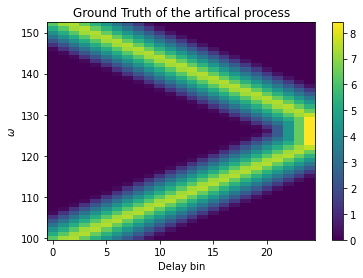

In [5]:
Nw = 53
Nt = 25
taxis, waxis = np.arange(Nt), np.arange(Nw)+100

Xtrue = np.zeros((Nw, Nt))
bb, aa = np.meshgrid(taxis, waxis)
for p1, p2 in zip([1,-1],[1,-1]):
    tmp = 0.1*(Nw+Nt) - abs((aa - waxis[Nw//2]) + p1* (bb - Nt//2) - p2* 0.2*(Nw+Nt))
    tmp[tmp<0] = 0
    Xtrue += tmp

plt.pcolormesh(taxis, waxis, Xtrue, shading="nearest")
plt.colorbar()
plt.title("Ground Truth of the artifical process")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

In [6]:
def axis2bin(axis):
    b = 0.5*(axis[1:]+axis[:-1])
    d0 = b[0]-axis[0]
    b = np.insert(b, 0, axis[0]-d0)
    d_1 = b[-1]-axis[-1]
    b = np.append(b, axis[-1]-d_1)
    return b

tbins = axis2bin(taxis)

In [7]:
Ns = 10000
np.random.seed(2022)
raw_spec_data = []
for i in range(Ns):
    # random artificial photon spectrum
    ai = np.random.rand(Nw) * 5 
    # random delay
    di = np.random.rand()*tbins.ptp() + tbins.min()
    jdelaybin = np.digitize(di, tbins)-1
    # yield
    yi = ai @ Xtrue[:,jdelaybin] + np.random.randn()*0.5
    raw_spec_data.append((ai, di, yi))

Now that `raw_spec_data` is a list of singleshot's `(photon_spectra, delay, yield)`, how to extract the underlying process?

Sparsely embedding yield into $B$ leads to poor results, so we project the expectation to the shot-specific delay bin before comparing to the measurement

### Why does directly embedding not work?
The objective in this way is 
$$f(X) = \sum_i \|a_i^TX-b_i^T\|^2 = \sum_{i,t} (a_i^TX_{:,t}-b_{i,t})^2$$
where $a_i^T\in \mathbb{R}_{1\times N_w}$ is the photon spectrum of shot $i$, $b_i^T\in \mathbb{R}_{1\times N_t}$ is the yield vector whose only non-zero entry is at the delay bin where shot $i$ falls in.

For each shot $i$, this objective penalizes the discrepancy on irrelavant delay bins as well as the delay bin that shot $i$ is in. This is the reason.

## Shot-specific Projection is What to do Instead
The objective should be the L2 of the discrepancy at the relevant delay bin only
$$h_0(X) = \sum_i \|(a_i^T\otimes e_{t_i}^T)X-b_i\|_2^2$$
where $e_{t_i}$ is the unit vector whose only unity entry is at the delay bin $t_i$ that shot $i$ falls in.
$$f(X) = \sum_i e_{t_i}^TX^Ta_ia_i^TXe_{t_i} - 2\sum_ib_ia_i^TXe_{t_i} +C$$

This is nothing but tensoring up $A = (a_i)$ into $A\otimes E = (a_i, e_{t_i})$

In [8]:
A = []
B = []
for ai, di, yi in raw_spec_data:
    jdelaybin = np.digitize(di, tbins)-1
    # There is a -1 because numpy.digitize returns 0 for values lower than the
    # 0-th entry in bins. 
    A.append((ai,jdelaybin))
    B.append(yi)
B = np.asarray(B)

In [15]:
SpookPosL1.verbose=True

In [16]:
spk1 = SpookPosL1(B, A, "ADraw", lsparse=0.0, lsmooth=(0.,0,1e-2))

1
Setting up the OSQP problem


Text(0.5, 0, 'Delay bin')

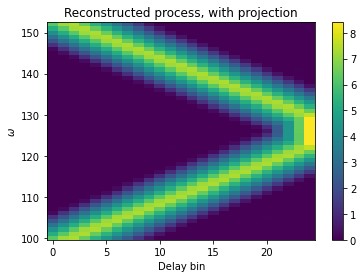

In [17]:
X1 = spk1.getXopt()
plt.pcolormesh(taxis, waxis, X1[:,:,0], shading="nearest")
plt.colorbar()
plt.title("Reconstructed process, with projection")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

Text(0.5, 0, 'Delay bin')

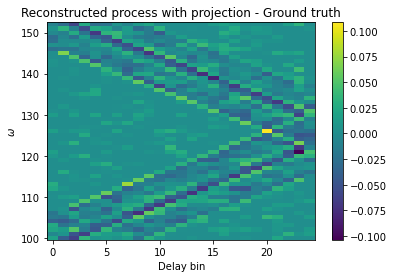

In [18]:
plt.pcolormesh(taxis, waxis, X1[:,:,0]-Xtrue, shading="nearest")
plt.colorbar()
plt.title("Reconstructed process with projection - Ground truth")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")

# Generalize to KE-resolved Yield
Regarding the delay as a tensoring axis to A helps generalizing to the KE-resolved case

In [19]:
Nw = 53
Nt = 25
Nb = 7
Ng = 11
taxis, waxis = np.arange(Nt), np.arange(Nw)+100
baxis = np.arange(Nb)+10

Xtrue = np.zeros((Nw, Nt, Nb))
tt, aa = np.meshgrid(taxis, waxis)
for b in np.arange(baxis.size):
    for p1, p2 in zip([1,-1],[1,-1]):
        p1 = p1 * (0.5 + b/(2*baxis.size))
        tmp = 0.1*(Nw+Nt) - abs((aa - waxis[Nw//2]) + p1* (tt - Nt//2) - p2* 0.2*(Nw+Nt))
        tmp[tmp<0] = 0
        Xtrue[:,:,b] += tmp

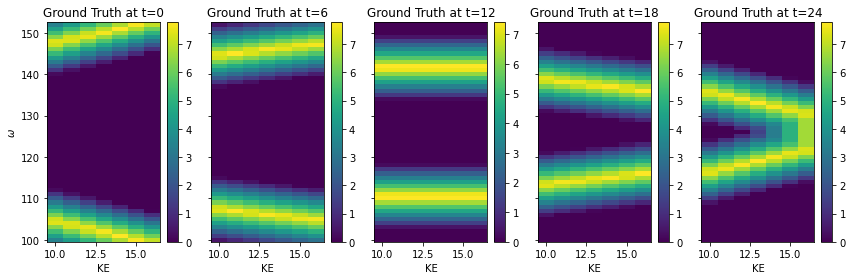

In [20]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, Xtrue[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Ground Truth at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

In [21]:
Ns = 10000
np.random.seed(2022)
raw_spec_data = {}
for i in range(Ns):
    # random artificial photon spectrum
    ai = np.random.rand(Nw) * 5 
    # random delay
    di = np.random.rand()*tbins.ptp() + tbins.min()
    jdelaybin = np.digitize(di, tbins)-1
    # yield
    yi = ai @ Xtrue[:,jdelaybin,:] + np.random.randn(Nb)*5
    raw_spec_data[i] = (ai, di, yi)

In [22]:
B = {k: dat[-1] for k, dat in raw_spec_data.items()}
A = {}
for k, dat in raw_spec_data.items():
    jdelaybin = np.digitize(dat[1], tbins) - 1
    A[k] = (dat[0], jdelaybin)

In [23]:
SpookPosL1.verbose=True

In [24]:
spk0 = SpookPosL1(B, A, "ADraw", lsparse=0.0, lsmooth=(0.,0.,1e-2))

X0 = spk0.getXopt()

Setting up the OSQP problem
Setting up the OSQP problem
Setting up the OSQP problem
Setting up the OSQP problem
Setting up the OSQP problem
Setting up the OSQP problem
Setting up the OSQP problem
Nonnegative constraints and L1 sparsity reg.
Solving Quad. Prog.


(53, 25, 7)

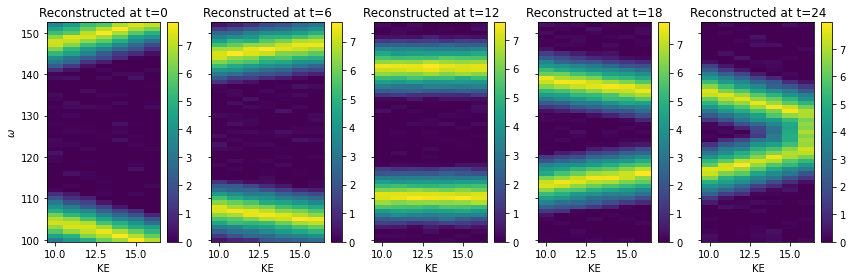

In [25]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X0[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

In [26]:
X0 = spk0.getXopt(lsparse=0.1, lsmooth=(1e-2,1e-2,1e-2))

Sparsity hyperparam updated.
Resetting problem to be flattened
Setting up the OSQP problem
Updated
Nonnegative constraints and L1 sparsity reg.
Solving Quad. Prog.


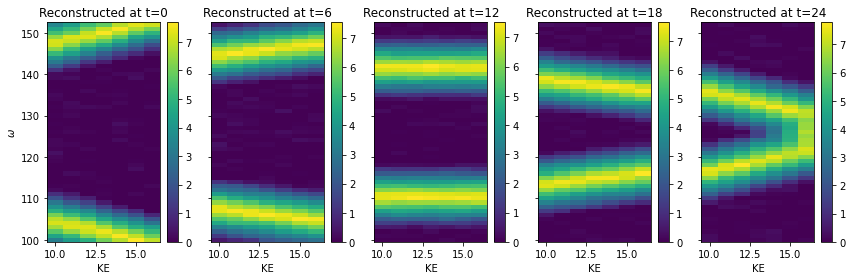

In [27]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X0[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

### With Non-trivial G
The objective should be the L2 of the discrepancy at the relevant delay bin only
$$h_0(C) = \sum_i \|(a_i^T\otimes e_{t_i}^T\otimes G^T)C-b_i\|_2^2$$

In [22]:
G = np.identity(Ng) - 0.2*np.diag(np.ones(Ng-1),k=-1) - 0.2*np.diag(np.ones(Ng-1),k=1)
G = G[:,:Nb]

In [23]:
Ns = 10000
np.random.seed(2022)
raw_spec_data = {}
for i in range(Ns):
    # random artificial photon spectrum
    ai = np.random.rand(Nw) * 5 
    # random delay
    di = np.random.rand()*tbins.ptp() + tbins.min()
    jdelaybin = np.digitize(di, tbins)-1
    # yield
    yi = ai @ Xtrue[:,jdelaybin,:] @ G.T + np.random.randn(Ng)*5
    raw_spec_data[i] = (ai, di, yi)

In [24]:
B = {k: dat[-1] for k, dat in raw_spec_data.items()}
A = {}
for k, dat in raw_spec_data.items():
    jdelaybin = np.digitize(dat[1], tbins) - 1
    A[k] = (dat[0], jdelaybin)

In [25]:
spk1 = SpookPosL1(B, A, "ADraw", G, lsparse=0.0, lsmooth=(0.,1e-2,1e-2))

X1 = spk1.getXopt()

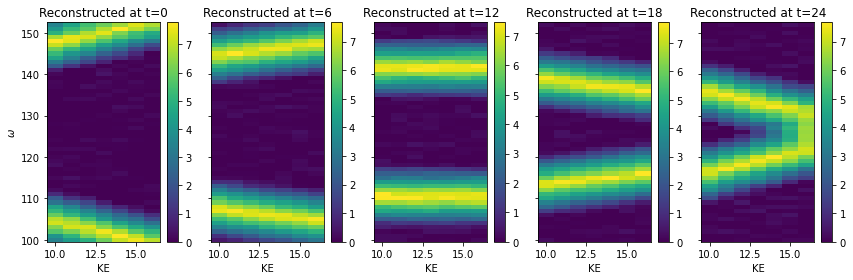

In [26]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X1[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

In [27]:
AtA = spk1._AtA
NaTuple = spk1.NaTuple
AtBG = spk1._Bcontracted

In [42]:
AtA.shape = (*NaTuple, *NaTuple)
AtBG.shape = (*NaTuple,-1)

In [43]:
GtG = G.T @ G

In [44]:
spk1ctr = SpookPosL1(AtBG, AtA, "contracted", GtG, lsparse=0.0, lsmooth=(0.,1e-2,1e-2))

In [45]:
X1ctr = spk1ctr.getXopt()

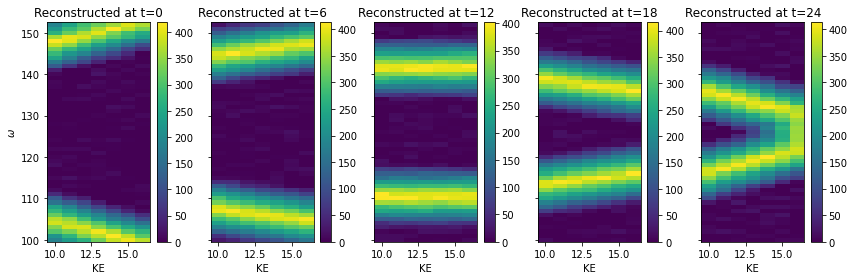

In [46]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X1ctr[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

In [47]:
X1ctr = spk1ctr.getXopt(lsparse=0.1, lsmooth=(0.,2e-2,1e-2))

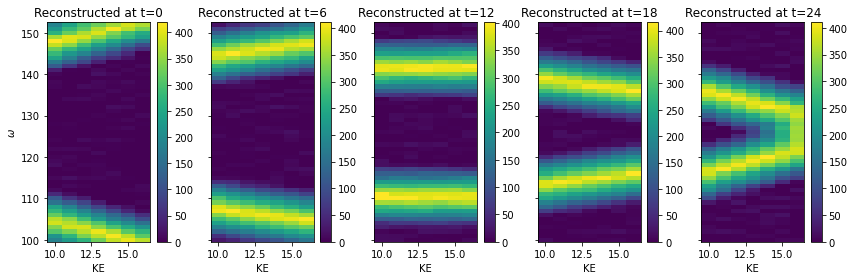

In [48]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X1ctr[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

In [29]:
spk1 = SpookLinSolve(B, A, "ADraw", G, lsparse=0.0, lsmooth=(0.,1e-2,1e-2))

In [37]:
X1 = spk1.getXopt(lsparse=1e-3, lsmooth=(1e-3,1e-3,1e-3))

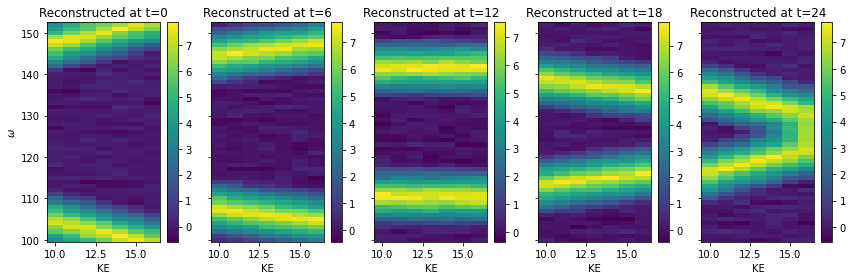

In [38]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(12,4))
for ax, t in zip(axs, [0,6,12,18,Nt-1]):
    im = ax.pcolormesh(baxis, waxis, X1[:,t,:], shading="nearest")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"Reconstructed at t={t}")
    ax.set_xlabel("KE")
axs[0].set_ylabel("$\omega$")
plt.tight_layout()

## 2B Discarded

In [7]:
A = []
B = []
for ai, di, yi in raw_spec_data:
    A.append(ai)
    jdelaybin = np.digitize(di, tbins)-1
    # There is a -1 because numpy.digitize returns 0 for values lower than the
    # 0-th entry in bins. 
    b = np.zeros((taxis.size,))
    b[jdelaybin] = yi
    B.append(b)
A, B = np.asarray(A), np.asarray(B)

In [8]:
SpookPosL1.verbose=True
spk0 = SpookPosL1(B, A, "raw", lsparse=0.1, lsmooth=(0.,0.0))

Setting up the OSQP problem


Sparsity hyperparam updated.
Setting up the OSQP problem
Updated
Nonnegative constraints and L1 sparsity reg.
Solving Quad. Prog.


Text(0.5, 0, 'Delay bin')

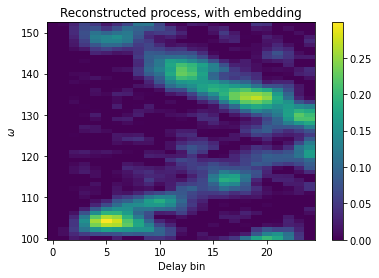

In [9]:
X0 = spk0.getXopt(lsparse=1e3, lsmooth=(1,1))
plt.pcolormesh(taxis, waxis, X0, shading="nearest")
plt.colorbar()
plt.title("Reconstructed process, with embedding")
plt.ylabel("$\omega$")
plt.xlabel("Delay bin")